In [26]:
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [27]:
# tickers = ['JNK', 'TLT']
# ydata = yf.Tickers(tickers).download(period="max", auto_adjust=True)   # get dividend adjusted price

In [28]:
# data = (   # put data in long form
#     ydata
#     .dropna()
#     .stack(1, future_stack=True)
#     .reset_index()
#     [['Date', 'Ticker', 'Close']]
#     .sort_values(by=['Date', 'Ticker'])
# )

# data.head(5)

In [29]:
# # download historical data from Yahoo Finance to csv, file name data_<tickers>_2002-07-30_D.csv
# data.to_csv('data_JNK_TLT_2007-12-04_D.csv', index=False)

In [30]:
# read data from csv
data = pd.read_csv('data_JNK_TLT_2007-12-04_D.csv')
data['Date'] = pd.to_datetime(data['Date'])
print(data.info())
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9018 entries, 0 to 9017
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9018 non-null   datetime64[ns]
 1   Ticker  9018 non-null   object        
 2   Close   9018 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 211.5+ KB
None
        Date Ticker      Close
0 2007-12-04    JNK  40.735722
1 2007-12-04    TLT  55.422939
2 2007-12-05    JNK  40.744225
3 2007-12-05    TLT  54.761887
4 2007-12-06    JNK  40.642155


In [31]:
# Add year-month label (end of month date)

# Convert Date column to datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Create a new column 'ym' representing the last day of each month
data['ym'] = data['Date'] + pd.offsets.MonthEnd(0)

data.head()

,Date,Ticker,Close,ym
0,2007-12-04,JNK,40.735722,2007-12-31
1,2007-12-04,TLT,55.422939,2007-12-31
2,2007-12-05,JNK,40.744225,2007-12-31
3,2007-12-05,TLT,54.761887,2007-12-31
4,2007-12-06,JNK,40.642155,2007-12-31


In [ ]:
"""
df starts from 2007-12-04

In the next cell, this will be marked as td = 1, but actually it is td = 3, 
since is the 3rd trading day of December 2007.

Overall, it makes little difference in this specific analysis, 
but it is better to be accurate if using this data for other purposes since, as an example, 
a starting day of 18th of a month would be marked as td = 1, which is not correct.

Due to this, in the next cell, I introduced a filter to keep data from a full month
"""

In [32]:
# Create trading-day counter for each Ticker and month

# Sort data to ensure correct order
data = data.sort_values(['Ticker', 'Date']).copy()

# Keep data from August 2008 onwards
data = data[data['Date'] >= pd.Timestamp(2008, 1, 1)]

# Count trading days within each (Ticker, ym) group
data['td'] = data.groupby(['Ticker', 'ym']).cumcount() + 1

# # add data['td'] column where td is the day of the month for each Ticker
# data['td'] = data['Date'].dt.day

data.head()

,Date,Ticker,Close,ym,td
38,2008-01-02,JNK,41.106148,2008-01-31,1
40,2008-01-03,JNK,40.746243,2008-01-31,2
42,2008-01-04,JNK,40.360615,2008-01-31,3
44,2008-01-07,JNK,40.591999,2008-01-31,4
46,2008-01-08,JNK,40.694832,2008-01-31,5


In [33]:
#  Calculate daily simple returns

# Calculate percentage change of 'Close' within each ticker
data['ret'] = data.groupby('Ticker')['Close'].pct_change()

data.head()

,Date,Ticker,Close,ym,td,ret
38,2008-01-02,JNK,41.106148,2008-01-31,1,NaN
40,2008-01-03,JNK,40.746243,2008-01-31,2,-0.008756
42,2008-01-04,JNK,40.360615,2008-01-31,3,-0.009464
44,2008-01-07,JNK,40.591999,2008-01-31,4,0.005733
46,2008-01-08,JNK,40.694832,2008-01-31,5,0.002533


In [34]:
# Filter dates and keep only needed columns

# Keep data from August 2002 onwards
data = data[data['Date'] >= pd.Timestamp(2002, 8, 1)]

# Keep only useful columns
data = data[['Date', 'ym', 'Ticker', 'Close', 'ret', 'td']]

data.head()

,Date,ym,Ticker,Close,ret,td
38,2008-01-02,2008-01-31,JNK,41.106148,NaN,1
40,2008-01-03,2008-01-31,JNK,40.746243,-0.008756,2
42,2008-01-04,2008-01-31,JNK,40.360615,-0.009464,3
44,2008-01-07,2008-01-31,JNK,40.591999,0.005733,4
46,2008-01-08,2008-01-31,JNK,40.694832,0.002533,5


In [35]:
# Create start/end/month flags and conditional returns

N = 15  # number of days for start of month
M = 5   # number of days for next start of month

# Flags: 1 if condition true, 0 otherwise
data['som_flag'] = (data['td'] <= N).astype(int)
data['eom_flag'] = (data['td'] > N).astype(int)
data['nsm_flag'] = (data['td'] <= M).astype(int)

# Conditional returns (return only within flag period)
data['ret_som'] = data['ret'] * data['som_flag']
data['ret_eom'] = data['ret'] * data['eom_flag']
data['ret_nsm'] = data['ret'] * data['nsm_flag']

# backward fill NaN returns with 0
data['ret_som'] = data['ret_som'].fillna(0)

data.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
38,2008-01-02,2008-01-31,JNK,41.106148,NaN,1,1,0,1,0.000000,NaN,NaN
40,2008-01-03,2008-01-31,JNK,40.746243,-0.008756,2,1,0,1,-0.008756,-0.0,-0.008756
42,2008-01-04,2008-01-31,JNK,40.360615,-0.009464,3,1,0,1,-0.009464,-0.0,-0.009464
44,2008-01-07,2008-01-31,JNK,40.591999,0.005733,4,1,0,1,0.005733,0.0,0.005733
46,2008-01-08,2008-01-31,JNK,40.694832,0.002533,5,1,0,1,0.002533,0.0,0.002533


In [36]:
# Keep only relevant return columns
data_flags = data[['Date', 'ym', 'Ticker', 'ret_som', 'ret_eom', 'ret_nsm']]

data_flags.head()

,Date,ym,Ticker,ret_som,ret_eom,ret_nsm
38,2008-01-02,2008-01-31,JNK,0.000000,NaN,NaN
40,2008-01-03,2008-01-31,JNK,-0.008756,-0.0,-0.008756
42,2008-01-04,2008-01-31,JNK,-0.009464,-0.0,-0.009464
44,2008-01-07,2008-01-31,JNK,0.005733,0.0,0.005733
46,2008-01-08,2008-01-31,JNK,0.002533,0.0,0.002533


In [37]:
# Pivot to wide format (one column per Ticker)

# Create wide format table: columns for each Ticker and return type
pivoted = data_flags.pivot(index=['Date', 'ym'], columns='Ticker')

# Flatten multi-level column names (e.g. ret_som_SPY)
pivoted.columns = [f"{col[1]}_{col[0]}" for col in pivoted.columns]

pivoted = pivoted.reset_index()

pivoted.head()

,Date,ym,JNK_ret_som,TLT_ret_som,JNK_ret_eom,TLT_ret_eom,JNK_ret_nsm,TLT_ret_nsm
0,2008-01-02,2008-01-31,0.000000,0.000000,NaN,NaN,NaN,NaN
1,2008-01-03,2008-01-31,-0.008756,-0.001377,-0.0,-0.0,-0.008756,-0.001377
2,2008-01-04,2008-01-31,-0.009464,0.000212,-0.0,0.0,-0.009464,0.000212
3,2008-01-07,2008-01-31,0.005733,0.004350,0.0,0.0,0.005733,0.004350
4,2008-01-08,2008-01-31,0.002533,-0.001162,0.0,-0.0,0.002533,-0.001162


In [38]:
# create a copy of data to be later used for the backtest analysis (8 PL streams in the backtesting)
backtest_data = pivoted.copy()

In [39]:
# Compute relative returns and aggregate monthly

# Calculate combined and relative returns
pivoted['JNK_ret'] = pivoted['JNK_ret_som'] + pivoted['JNK_ret_eom']
pivoted['JNK_TLT_som'] = pivoted['JNK_ret_som'] - pivoted['TLT_ret_som']
pivoted['JNK_TLT_eom'] = pivoted['JNK_ret_eom'] - pivoted['TLT_ret_eom']
pivoted['JNK_TLT_nsm'] = pivoted['JNK_ret_nsm'] - pivoted['TLT_ret_nsm']

# Add TLT_ret column
pivoted['TLT_ret'] = pivoted['TLT_ret_som'] + pivoted['TLT_ret_eom']

# Select relevant columns
returns = pivoted[['ym', 'JNK_ret', 'JNK_TLT_som', 'JNK_TLT_eom', 'JNK_TLT_nsm', 'TLT_ret']]

# Aggregate monthly returns using compounding formula
monthly = returns.groupby('ym').apply(lambda x: (1 + x).prod() - 1)

monthly.head()

,JNK_ret,JNK_TLT_som,JNK_TLT_eom,JNK_TLT_nsm,TLT_ret
ym,,,,,
2008-01-31,-0.025433,-0.061464,0.029511,-0.011986,0.006463
2008-02-29,-0.034403,-0.000566,-0.031486,-0.000718,-0.004552
2008-03-31,0.004647,-0.023398,0.004746,0.018015,0.021387
2008-04-30,0.037240,0.051203,0.010680,0.017045,-0.024862
2008-05-31,0.003873,0.012606,0.018012,0.020432,-0.026883


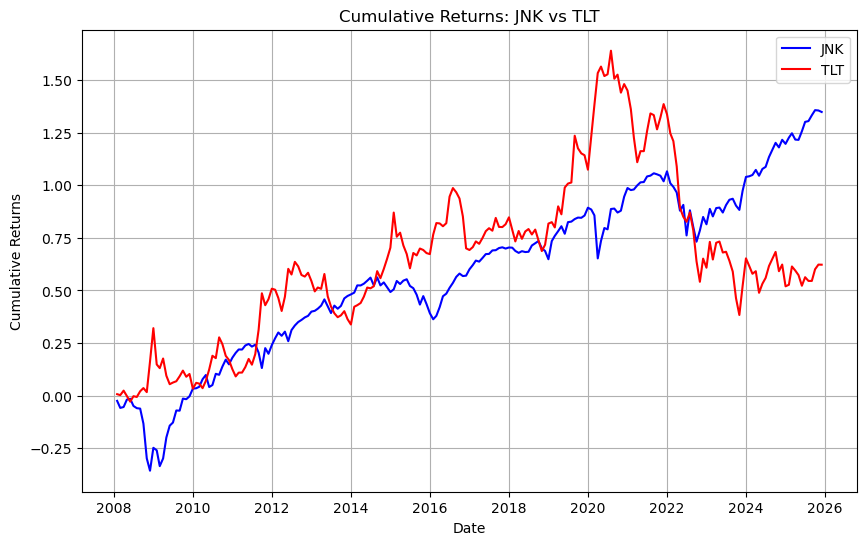

In [40]:
# calculate cumulative returns for JNK_ret and TLT_ret
monthly['JNK_cumret'] = (1 + monthly['JNK_ret']).cumprod() - 1
monthly['TLT_cumret'] = (1 + monthly['TLT_ret']).cumprod() - 1

# plot JNK_ret vs TLT_ret to compare their performance
plt.figure(figsize=(10, 6))
plt.plot(monthly.index, monthly['JNK_cumret'], label='JNK', color='blue')
plt.plot(monthly.index, monthly['TLT_cumret'], label='TLT', color='red')
plt.title('Cumulative Returns: JNK vs TLT')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

In [41]:
monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2008-01-31 to 2025-11-30
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   JNK_ret      215 non-null    float64
 1   JNK_TLT_som  215 non-null    float64
 2   JNK_TLT_eom  215 non-null    float64
 3   JNK_TLT_nsm  215 non-null    float64
 4   TLT_ret      215 non-null    float64
 5   JNK_cumret   215 non-null    float64
 6   TLT_cumret   215 non-null    float64
dtypes: float64(7)
memory usage: 13.4 KB


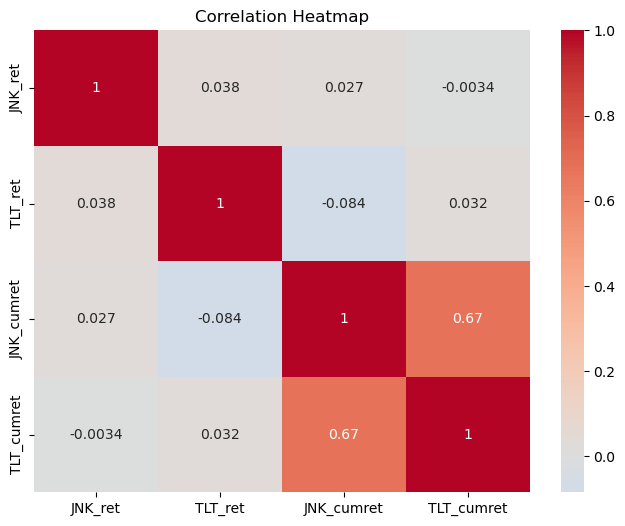

In [42]:
# plot correlation heatmap of JNK_ret, TLT_ret, JNK_cumret, TLT_cumret
plt.figure(figsize=(8, 6))
sns.heatmap(monthly[['JNK_ret', 'TLT_ret', 'JNK_cumret', 'TLT_cumret']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [43]:
return_data = monthly.copy()

In [44]:
# Average daily returns of TLT and JNK
# Keep only rows where the ticker is 'TLT' 
tlt = data[data['Ticker'] == 'TLT'].copy()

# Show first rows to check the result 
tlt.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
39,2008-01-02,2008-01-31,TLT,55.434231,NaN,1,1,0,1,0.000000,NaN,NaN
41,2008-01-03,2008-01-31,TLT,55.357883,-0.001377,2,1,0,1,-0.001377,-0.0,-0.001377
43,2008-01-04,2008-01-31,TLT,55.369637,0.000212,3,1,0,1,0.000212,0.0,0.000212
45,2008-01-07,2008-01-31,TLT,55.610493,0.004350,4,1,0,1,0.004350,0.0,0.004350
47,2008-01-08,2008-01-31,TLT,55.545868,-0.001162,5,1,0,1,-0.001162,-0.0,-0.001162


In [45]:
# Add 'ym' column as the end of the month for each date 
tlt['ym'] = tlt['Date'] + pd.offsets.MonthEnd(0)

# Calculate daily return based on the Close price 
tlt['ret'] = tlt['Close'].pct_change()

# Show the first few rows with new columns 
tlt.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
39,2008-01-02,2008-01-31,TLT,55.434231,NaN,1,1,0,1,0.000000,NaN,NaN
41,2008-01-03,2008-01-31,TLT,55.357883,-0.001377,2,1,0,1,-0.001377,-0.0,-0.001377
43,2008-01-04,2008-01-31,TLT,55.369637,0.000212,3,1,0,1,0.000212,0.0,0.000212
45,2008-01-07,2008-01-31,TLT,55.610493,0.004350,4,1,0,1,0.004350,0.0,0.004350
47,2008-01-08,2008-01-31,TLT,55.545868,-0.001162,5,1,0,1,-0.001162,-0.0,-0.001162


In [46]:
tlt_filtered = tlt.copy()

# For each month, number the days starting from 1 
tlt_filtered['td'] = tlt_filtered.groupby('ym').cumcount() + 1

# Show some rows to verify 
tlt_filtered.head()

,Date,ym,Ticker,Close,ret,td,som_flag,eom_flag,nsm_flag,ret_som,ret_eom,ret_nsm
39,2008-01-02,2008-01-31,TLT,55.434231,NaN,1,1,0,1,0.000000,NaN,NaN
41,2008-01-03,2008-01-31,TLT,55.357883,-0.001377,2,1,0,1,-0.001377,-0.0,-0.001377
43,2008-01-04,2008-01-31,TLT,55.369637,0.000212,3,1,0,1,0.000212,0.0,0.000212
45,2008-01-07,2008-01-31,TLT,55.610493,0.004350,4,1,0,1,0.004350,0.0,0.004350
47,2008-01-08,2008-01-31,TLT,55.545868,-0.001162,5,1,0,1,-0.001162,-0.0,-0.001162


In [47]:
# Group by the trading day number and take the mean of returns 
avg_daily_returns = tlt_filtered.groupby('td')['ret'].mean().reset_index()

#  Display the last few rows to see results 
avg_daily_returns.tail()

,td,ret
18,19,0.001759
19,20,0.001563
20,21,0.000885
21,22,0.001598
22,23,0.000443


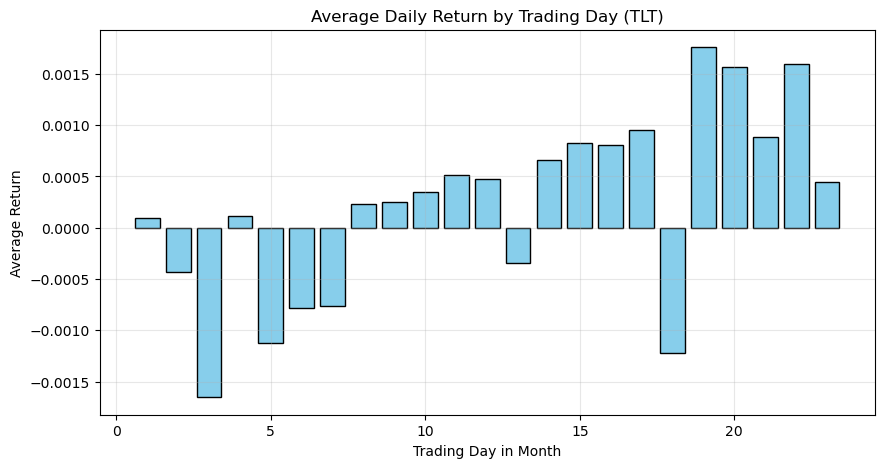

,td,ret
18,19,0.001759
19,20,0.001563
20,21,0.000885
21,22,0.001598
22,23,0.000443


In [48]:
# Plot average daily returns using matplotlib 
plt.figure(figsize=(10, 5))
plt.bar(avg_daily_returns['td'], avg_daily_returns['ret'], color='skyblue', edgecolor='black')

# Add labels and title 
plt.title("Average Daily Return by Trading Day (TLT)")
plt.xlabel("Trading Day in Month")
plt.ylabel("Average Return")
plt.grid(alpha=0.3)

plt.show()

# Show the last few rows of the data for reference 
avg_daily_returns.tail()

In [49]:
avg_daily_returns

,td,ret
0,1,0.000096
1,2,-0.000435
2,3,-0.001653
3,4,0.000118
4,5,-0.001125
5,6,-0.000784
6,7,-0.000762
7,8,0.000235
8,9,0.000247
9,10,0.000353


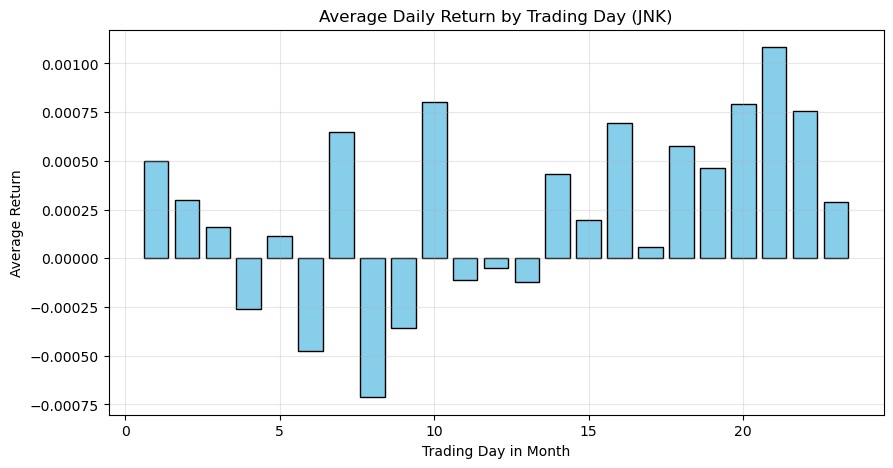

,td,ret
18,19,0.000463
19,20,0.000792
20,21,0.001084
21,22,0.000755
22,23,0.000289


In [50]:
# Keep only rows where the ticker is 'JNK'
jnk = data[data['Ticker'] == 'JNK'].copy()

# Add 'ym' column as the end of the month for each date
jnk['ym'] = jnk['Date'] + pd.offsets.MonthEnd(0)

# Calculate daily return based on the Close price
jnk['ret'] = jnk['Close'].pct_change()

# Keep only data after 1st August 2002
jnk_filtered = jnk[jnk['Date'] >= dt.datetime(2002, 8, 1)].copy()

# For each month, number the days starting from 1
jnk_filtered['td'] = jnk_filtered.groupby('ym').cumcount() + 1

# Group by the trading day number and take the mean of returns
avg_daily_returns_jnk = jnk_filtered.groupby('td')['ret'].mean().reset_index()

# Plot average daily returns using matplotlib
plt.figure(figsize=(10, 5))
plt.bar(avg_daily_returns_jnk['td'], avg_daily_returns_jnk['ret'], color='skyblue', edgecolor='black')

# Add labels and title
plt.title("Average Daily Return by Trading Day (JNK)")
plt.xlabel("Trading Day in Month")
plt.ylabel("Average Return")
plt.grid(alpha=0.3)

plt.show()

# Show the last few rows of the data for reference
avg_daily_returns_jnk.tail()